In [2]:
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import numpy as np
import polars as pl
import gsd.hoomd
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

import glob
import os
import pathlib
import pickle
import signac
import freud
from numba import njit

from dataclasses import dataclass
from collections import defaultdict

import matplotlib.pyplot as plt
from scipy import stats

In [3]:
from monk import workflow, utils

/home/ian/micromamba/envs/softness-autoencoder/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [6]:
pipe = None
pipe0 = None
pipe1 = None
with open("svc.pkl", "rb") as f:
    pipe = pickle.load(f)

with open("svc_type0.pkl", "rb") as f:
    pipe0 = pickle.load(f)

with open("svc_type1.pkl", "rb") as f:
    pipe1 = pickle.load(f)

/home/ian/micromamba/envs/softness-autoencoder/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ian/micromamba/envs/softness-autoencoder/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.1.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ian/micromamba/envs/softness-autoencoder/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to 

In [7]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [ ]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/auto-encoder-dataset-v2_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        if job.isfile(df_path):
            # dataset = pl.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        traj = gsd.hoomd.open(exper)
        # oexper = exper.replace("traj-fire", "traj")
        # otraj = gsd.hoomd.open(oexper)

        # print(len(traj))
        
        # print(max_shear, period, temp)

        # softness = []
        # frames = []
        # types = []
        # sfs = []
        start = 199
        # end = 201
        cycle_start_idx = lambda i: -1 + i*40
        # for frame in tqdm(range(cycle_start_idx(start), cycle_start_idx(end),
        # 40)):
        frame = cycle_start_idx(start)


        snap = traj[frame]

        typeids = snap.particles.typeid
        softb = np.zeros_like(typeids, dtype=np.float32)

        query_indices0 = np.arange(snap.particles.N)[typeids == 0]
        sfs0 = ml.compute_structure_functions_snap(snap, query_indices0)
        soft0 = pipe0.decision_function(sfs0)

        query_indices1 = np.arange(snap.particles.N)[typeids == 1]
        sfs1 = ml.compute_structure_functions_snap(snap, query_indices1)
        soft1 = pipe1.decision_function(sfs1)

        softb[typeids == 0] = soft0
        softb[typeids == 1] = soft1

        # softness.append(softb)

        all_sfs = np.zeros((snap.particles.N, sfs1.shape[1]), dtype=np.float32)

        all_sfs[typeids == 0] = sfs0
        all_sfs[typeids == 1] = sfs1

        frames = np.ones_like(typeids, dtype=np.int32) * frame

        strains = np.ones_like(typeids, dtype=np.float32) * float(max_shear)

        snap_high = traj[10 + frame]
        snap_later = traj[40 + frame]
        snap_low = traj[30 + frame]

        box = snap.configuration.box[:]
        box_high = snap_high.configuration.box[:]
        box_later = snap_later.configuration.box[:]
        box_low = snap_low.configuration.box[:]

        nlist_query = freud.locality.LinkCell.from_system(snap)
        nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 10}).toNeighborList()

        d2min_irr = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
        d2min_rev = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
        # d2min_c = np.sqrt(np.square(d2min_rev) + np.square(d2min_irr)) * np.sign(d2min_rev - d2min_irr)

        nlist_query = freud.locality.LinkCell.from_system(snap)
        nlist = nlist_query.query(snap.particles.position, {'num_neighbors': 20}).toNeighborList()

        d2min_irr_20 = schmeud_rs.dynamics.d2min_frame(snap.particles.position[:, :2], snap_later.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box, box_later))
        d2min_rev_20 = schmeud_rs.dynamics.d2min_frame(snap_high.particles.position[:, :2], snap_low.particles.position[:, :2], nlist.query_point_indices, nlist.point_indices, (box_high, box_low))
        # d2min_c = np.sqrt(np.square(d2min_rev) + np.square(d2min_irr)) * np.sign(d2min_rev - d2min_irr)

        dataset = pl.DataFrame({"frame": frames, "strain": strains, "id": np.array(typeids), "soft": np.array(softb), "sfs": all_sfs, "d2min_irr_10": d2min_irr, "d2min_rev_10": d2min_rev, "d2min_irr_20": d2min_irr_20, "d2min_rev_20": d2min_rev_20})
        # dataset = dataset.explode(["id", "soft"]).reset_index(drop=True)
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)
    #     break
    # break


In [8]:
def get_pr(soft, prep):
    if prep == "HTL":
        fit = [0.14949216, 0.39594848]
    elif prep == "ESL":
        fit = [0.19945844, 0.42320983]
    else:
        raise ValueError(f"Unknown prep {prep}")
    return fit[0] * soft + fit[1]

In [9]:
# output = defaultdict(list)
x = np.linspace(-1.0, 1.0, 11)
x2 = (x[1:] + x[:-1]) / 2
l = [f"{x:.2f}" for x in x2]
l.insert(0, "-inf")
l.append("inf")

datasets = []

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/auto-encoder-dataset-v1_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) != 0.019836 or float(max_shear) != 0.04:
            continue

        dataset = pl.read_parquet(job.fn(df_path))

        cuts = dataset["soft"].cut(x, labels=l)

        sf_len = dataset[0]["sfs"][0].shape[0]
        X = np.zeros((len(dataset), sf_len + 4), dtype=np.float32)
        X[:, 0] = dataset["strain"]
        X[:, 1] = (dataset["id"] == 0)
        X[:, 2] = (dataset["id"] == 1)
        X[:, 3:-1] = np.vstack(dataset["sfs"].to_numpy())
        X[:, -1] = dataset["soft"]

        dataset = dataset.with_columns(
            sfs = X,
            pr = pl.col("soft").map_batches(lambda x: get_pr(x, prep)),
            prep = pl.lit(prep),
            cuts = cuts
        )

        # output[sp].append(dataset)
        datasets.append(dataset)

dataset = pl.concat(datasets)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [11]:
dataset.head()

frame,strain,id,soft,sfs,d2min_irr_10,d2min_rev_10,d2min_irr_20,d2min_rev_20,pr,prep,cuts
i32,f32,u32,f32,list[f32],f32,f32,f32,f32,f32,str,cat
7959,0.04,1,-0.864295,"[0.04, 0.0, … -0.864295]",0.000117,0.086112,0.000332,0.184264,0.266743,"""HTL""","""-0.90"""
7959,0.04,0,0.624044,"[0.04, 1.0, … 0.624044]",0.000116,0.065206,0.000228,0.12339,0.489238,"""HTL""","""0.70"""
7959,0.04,1,0.450813,"[0.04, 0.0, … 0.450813]",0.000036,0.045519,0.000174,0.106589,0.463341,"""HTL""","""0.50"""
7959,0.04,0,-0.10508,"[0.04, 1.0, … -0.10508]",0.000245,0.040277,0.000524,0.097985,0.38024,"""HTL""","""-0.10"""
7959,0.04,0,0.8924,"[0.04, 1.0, … 0.8924]",0.000077,0.018019,0.000195,0.058571,0.529355,"""HTL""","""0.90"""


In [12]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_input_channels, base_channel_size),
            act_fn(),
            nn.Linear(base_channel_size, base_channel_size//2),
            act_fn(),
            nn.Linear(base_channel_size//2, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, base_channel_size: int, latent_dim: int, act_fn: object = nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 1, base_channel_size//2),
            act_fn(),
            nn.Linear(base_channel_size//2, base_channel_size),
            act_fn(),
            nn.Linear(base_channel_size, 1),
            # nn.Sigmoid()
            # nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class AutoEncoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.ReLU):
        super().__init__()
        self.encoder = Encoder(num_input_channels, base_channel_size, latent_dim, act_fn)
        self.decoder = Decoder(base_channel_size, latent_dim, act_fn)

    def forward(self, x):
        soft = x[:, -1].view(-1, 1)
        x = self.encoder(x[:,:-1])
        x = self.decoder(torch.cat((x, soft), 1))
        return x

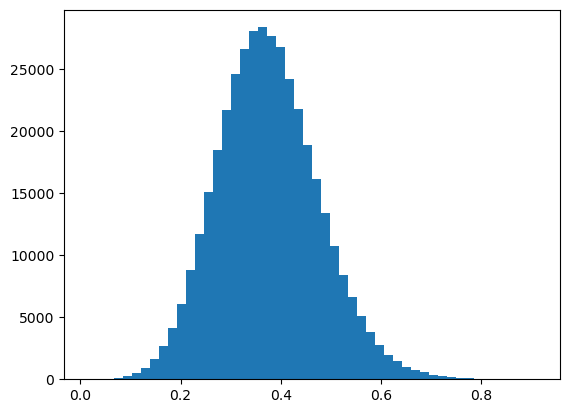

In [14]:
plt.hist(dataset["pr"], bins=50);

In [28]:
# Y = (dataset["d2min_rev_10"] > 0.08).to_numpy().astype(np.float32)
# Y = np.log(dataset["d2min_rev_10"].to_numpy())
Y = dataset["pr"].to_numpy()

data_len = len(Y)
sf_len = dataset[0]["sfs"][0].shape[0]

X = np.zeros((data_len, sf_len + 4), dtype=np.float32)
X[:, 0] = dataset["strain"]
X[:, 1] = (dataset["id"] == 0)
X[:, 2] = (dataset["id"] == 1)
# X[:, 3] = (dataset["prep"] == "ESL")
# X[:, 4] = (dataset["prep"] == "HTL")
X[:, 3:-1] = np.vstack(dataset["sfs"].to_numpy())
X[:, -1] = dataset["soft"]

X, Y

(array([[ 0.04      ,  0.        ,  1.        , ...,  2.1445243 ,
         -0.86429465, -0.86429465],
        [ 0.04      ,  1.        ,  0.        , ...,  1.5466106 ,
          0.6240445 ,  0.6240445 ],
        [ 0.04      ,  0.        ,  1.        , ...,  0.15680748,
          0.45081285,  0.45081285],
        ...,
        [ 0.04      ,  0.        ,  1.        , ...,  0.2763454 ,
         -0.86067826, -0.86067826],
        [ 0.04      ,  1.        ,  0.        , ...,  1.3275038 ,
          0.0054784 ,  0.0054784 ],
        [ 0.04      ,  0.        ,  1.        , ...,  3.0052066 ,
         -0.1053692 , -0.1053692 ]], dtype=float32),
 array([0.26674318, 0.48923823, 0.46334144, ..., 0.25154027, 0.42430252,
        0.40219304], dtype=float32))

In [29]:

# Normalizing Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(Y.reshape(-1, 1))

X_scaled, Y_scaled = shuffle(X_scaled, Y_scaled)

# Converting to PyTorch tensor
X_tensor = torch.FloatTensor(X_scaled)
Y_tensor = torch.FloatTensor(Y_scaled)

In [30]:
import torch.utils.data as data_utils

torch_dataset = data_utils.TensorDataset(X_tensor.to(device), Y_tensor.to(device))
train_len = int(data_len*0.5)
train, test = data_utils.random_split(torch_dataset, [train_len, data_len - train_len])
train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=data_len - train_len)

In [31]:
# Setting random seed for reproducibility
torch.manual_seed(42)

input_size = X.shape[1]  # Number of input features
encoding_dim = 1  # Desired number of output dimensions
model = AutoEncoder(input_size - 1, 512, encoding_dim).to(device)

# Loss function and optimizer
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [32]:


# Training the autoencoder
# num_epochs = 20
# for epoch in range(num_epochs):
#    # Forward pass
#    outputs = model(X_tensor)
#    loss = criterion(outputs, X_tensor)

#    # Backward pass and optimization
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

n_epochs = 5
for epoch in range(n_epochs):
   for X_batch, y_batch in train_loader:
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

   for X_test, y_test in test_loader:
      y_pred = model(X_test)
      loss = loss_fn(y_pred, y_test)


      # Loss for each epoch
      print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

# Encoding the data using the trained autoencoder
# encoded_data = model.encoder(X_tensor).detach().numpy()

Epoch [1/5], Loss: 0.0240
Epoch [2/5], Loss: 0.0260
Epoch [3/5], Loss: 0.0232
Epoch [4/5], Loss: 0.0239
Epoch [5/5], Loss: 0.0237


host_model = model.to("cpu")
host_model.encoder(dataset[0]["sfs"][0][:-1])

Text(0.5, 1.0, 'Prep information EXCLUDED')

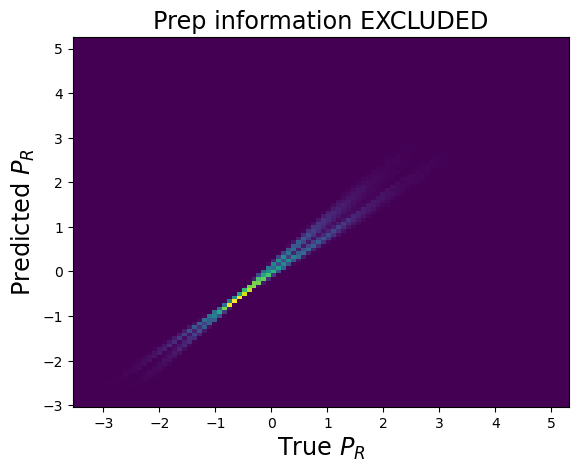

In [34]:
plt.hist2d(y_test.cpu().detach().numpy()[:,0], y_pred.cpu().detach().numpy()[:,0], bins=100);
plt.xlabel(r"True $P_R$", size="xx-large")
plt.ylabel(r"Predicted $P_R$", size="xx-large")
plt.title(r"Prep information EXCLUDED", size="xx-large")

In [83]:
stats.pearsonr(y_test.cpu().detach().numpy()[:,0], y_pred.cpu().detach().numpy()[:,0])

PearsonRResult(statistic=0.9883990317308475, pvalue=0.0)